In [1]:
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
from scipy.interpolate import interp1d

2022-04-01 12:53:42.750799: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-01 12:53:42.750814: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2022-04-01 12:53:44.071423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-01 12:53:44.071438: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-01 12:53:44.071452: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (isidro-pc): /proc/driver/nvidia/version does not exist


In [4]:
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1805285954025146203
]


2022-04-01 12:53:44.097337: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import pandas as pd
df=pd.read_csv('jla.csv')

In [6]:
dmag =df["dmb"]

In [7]:
#df = df[["zcmb", "mb","errors"]]

In [8]:
N = len(df.values)

(0.0, 1.2991059999999999)

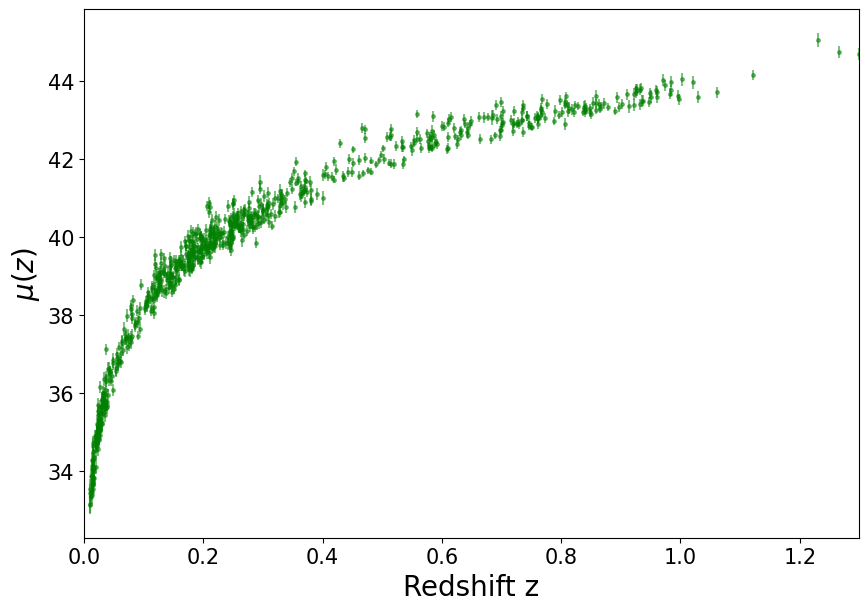

In [9]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb']+19, df['errors'], fmt='g.', markersize=5, label='Observations', alpha=0.5)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xscale('log')


plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlim(0, max(df['zcmb']))

In [10]:
randomize = np.random.permutation(N)
data = df.values[randomize]

In [11]:
z = data[:,0]
y = data[:,1:] ### coge el resto de variables a predecir 
# print(randomize)

In [12]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [13]:
### Modificar para incluir phanteon como test
split = 0.75
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [14]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=50.0,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]

In [15]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.09, wa=0.3, Om=om))
#     fowacdm2.append(distance_modulus(zzz, w0=-1.04, wa=-0.3, Om=om))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

In [16]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.75
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((555, 1), (555, 1), (185, 1), (185, 1))

In [17]:
from astroNN.nn.layers import MCDropout

In [ ]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[3], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                 activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=3, activation="linear"))
    return model

#Define some parameter
batch_size = 1
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[100, 150, 200,150])
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=1000,verbose=1,
                                    validation_data=(z_test, y_test))

/home/isidro/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-04-01 12:53:44.675541: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
555/555 [==============================] - 1s 822us/step - loss: 82.7039 - val_loss: 24.8551
Epoch 2/1000
555/555 [==============================] - 0s 677us/step - loss: 19.1059 - val_loss: 15.2916
Epoch 3/1000
555/555 [==============================] - 0s 653us/step - loss: 11.3894 - val_loss: 9.1646
Epoch 4/1000
555/555 [==============================] - 0s 657us/step - loss: 7.7260 - val_loss: 5.4987
Epoch 5/1000
555/555 [==============================] - 0s 653us/step - loss: 5.3994 - val_loss: 4.1009
Epoch 6/1000
555/555 [==============================] - 0s 657us/step - loss: 4.5403 - val_loss: 3.9357
Epoch 7/1000
555/555 [==============================] - 0s 665us/step - loss: 4.3885 - val_loss: 3.8328
Epoch 8/1000
555/555 [==============================] - 0s 661us/step - loss: 3.9511 - val_loss: 3.6799
Epoch 9/1000
555/555 [==============================] - 0s 682us/step - loss: 3.5414 - val_loss: 3.8225
Epoch 10/1000
555/555 [==============================] - 0s

555/555 [==============================] - 0s 661us/step - loss: 1.2963 - val_loss: 1.3380
Epoch 80/1000
555/555 [==============================] - 0s 654us/step - loss: 1.3141 - val_loss: 1.2330
Epoch 81/1000
555/555 [==============================] - 0s 660us/step - loss: 1.3634 - val_loss: 1.2680
Epoch 82/1000
555/555 [==============================] - 0s 649us/step - loss: 1.3404 - val_loss: 1.1954
Epoch 83/1000
555/555 [==============================] - 0s 656us/step - loss: 1.2574 - val_loss: 1.1862
Epoch 84/1000
555/555 [==============================] - 0s 649us/step - loss: 1.3126 - val_loss: 1.2448
Epoch 85/1000
555/555 [==============================] - 0s 661us/step - loss: 1.0598 - val_loss: 1.3331
Epoch 86/1000
555/555 [==============================] - 0s 664us/step - loss: 1.3001 - val_loss: 1.3658
Epoch 87/1000
555/555 [==============================] - 0s 654us/step - loss: 1.1313 - val_loss: 1.1627
Epoch 88/1000
555/555 [==============================] - 0s 659us/ste

555/555 [==============================] - 0s 671us/step - loss: 1.0943 - val_loss: 1.0091
Epoch 157/1000
555/555 [==============================] - 0s 638us/step - loss: 1.1339 - val_loss: 0.9487
Epoch 158/1000
555/555 [==============================] - 0s 682us/step - loss: 1.0642 - val_loss: 1.1293
Epoch 159/1000
555/555 [==============================] - 0s 674us/step - loss: 1.0262 - val_loss: 1.2616
Epoch 160/1000
555/555 [==============================] - 0s 667us/step - loss: 1.2186 - val_loss: 1.3501
Epoch 161/1000
555/555 [==============================] - 0s 640us/step - loss: 1.0973 - val_loss: 1.0997
Epoch 162/1000
555/555 [==============================] - 0s 654us/step - loss: 1.0868 - val_loss: 1.0847
Epoch 163/1000
555/555 [==============================] - 0s 630us/step - loss: 1.0362 - val_loss: 1.0092
Epoch 164/1000
555/555 [==============================] - 0s 641us/step - loss: 1.1071 - val_loss: 1.0355
Epoch 165/1000
555/555 [==============================] - 0s 

555/555 [==============================] - 0s 632us/step - loss: 1.0872 - val_loss: 1.0134
Epoch 234/1000
555/555 [==============================] - 0s 631us/step - loss: 1.1105 - val_loss: 0.9374
Epoch 235/1000
555/555 [==============================] - 0s 666us/step - loss: 0.9819 - val_loss: 1.1287
Epoch 236/1000
555/555 [==============================] - 0s 648us/step - loss: 1.0213 - val_loss: 0.8682
Epoch 237/1000
555/555 [==============================] - 0s 643us/step - loss: 1.0552 - val_loss: 0.9946
Epoch 238/1000
555/555 [==============================] - 0s 672us/step - loss: 0.8647 - val_loss: 1.0289
Epoch 239/1000
555/555 [==============================] - 0s 647us/step - loss: 1.0301 - val_loss: 1.1388
Epoch 240/1000
555/555 [==============================] - 0s 651us/step - loss: 1.1885 - val_loss: 1.1081
Epoch 241/1000
555/555 [==============================] - 0s 660us/step - loss: 0.9363 - val_loss: 0.9751
Epoch 242/1000
555/555 [==============================] - 0s 

In [ ]:
# Generate test data
test_batch_size = 10
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 3))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [ ]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

In [ ]:
np.max(sigma)

In [ ]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
# plt.errorbar(df['zcmb'], df['mb'], df['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.8, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,2)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()


In [ ]:
 prediction_mc_dropout[0,:]

In [ ]:
plt.figure(figsize=(3, 2), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.xticks([])
plt.yticks([])


In [ ]:
mookdp = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("data.dat",mookdp, delimiter=" ")

In [ ]:
dfMook = pd.DataFrame(mookdp, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50hdmookdropout.png")

In [ ]:
model.save('FFNN_MCDO3.h5')

PREDICCIÓN SOBRE DATOS DE TESTEO 

In [ ]:
from keras.models import load_model

In [ ]:
model2 = load_model('/content/FFNN_MCDO3.h5', custom_objects={'MCDropout': MCDropout})

In [ ]:
import pandas as pd
df=pd.read_csv('/content/not_in _jla.csv')

In [ ]:
dmag =df["dmb"]

In [ ]:
#df = df[["zcmb", "mb","errors"]]

In [ ]:
N = len(df.values)

In [ ]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb']+19, df['errors'], fmt='g.', markersize=5, label='Observations', alpha=0.5)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xscale('log')


plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlim(0, 2.3)

In [ ]:
randomize = np.random.permutation(N)
data = df.values[randomize]

In [ ]:
z = data[:,0]
y = data[:,1:] ### coge el resto de variables a predecir 
# print(randomize)

In [ ]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [ ]:
### Modificar para incluir phanteon como test
split = 0.0
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [ ]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.09, wa=0.3, Om=om))
#     fowacdm2.append(distance_modulus(zzz, w0=-1.04, wa=-0.3, Om=om))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

In [ ]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.0
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

In [ ]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 3))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model2.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [ ]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

In [ ]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df['zcmb'], df['mb'], df['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,2)
plt.xlim(0, 1.3)
# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()
plt.savefig("prediction_MCDO.png")